PREDICTION DE FRAIS MEDICAUX

Importation des librairies


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skopt.space import Real, Categorical
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Importation et lecture du fichier CSV


In [4]:
# Lecture du csv
df = pd.read_csv('insurance.csv')

# Afficher les premières lignes du DataFrame pour vérifier l'importation
display(df.head())
display(df.tail())

# Afficher des informations sur le DataFrame
df.info()

# Afficher les statistiques descriptives
df.describe()

# Valeurs manquantes du DataFrame
missing_values = df.isnull().sum()
missing_values

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

Visualisations des données

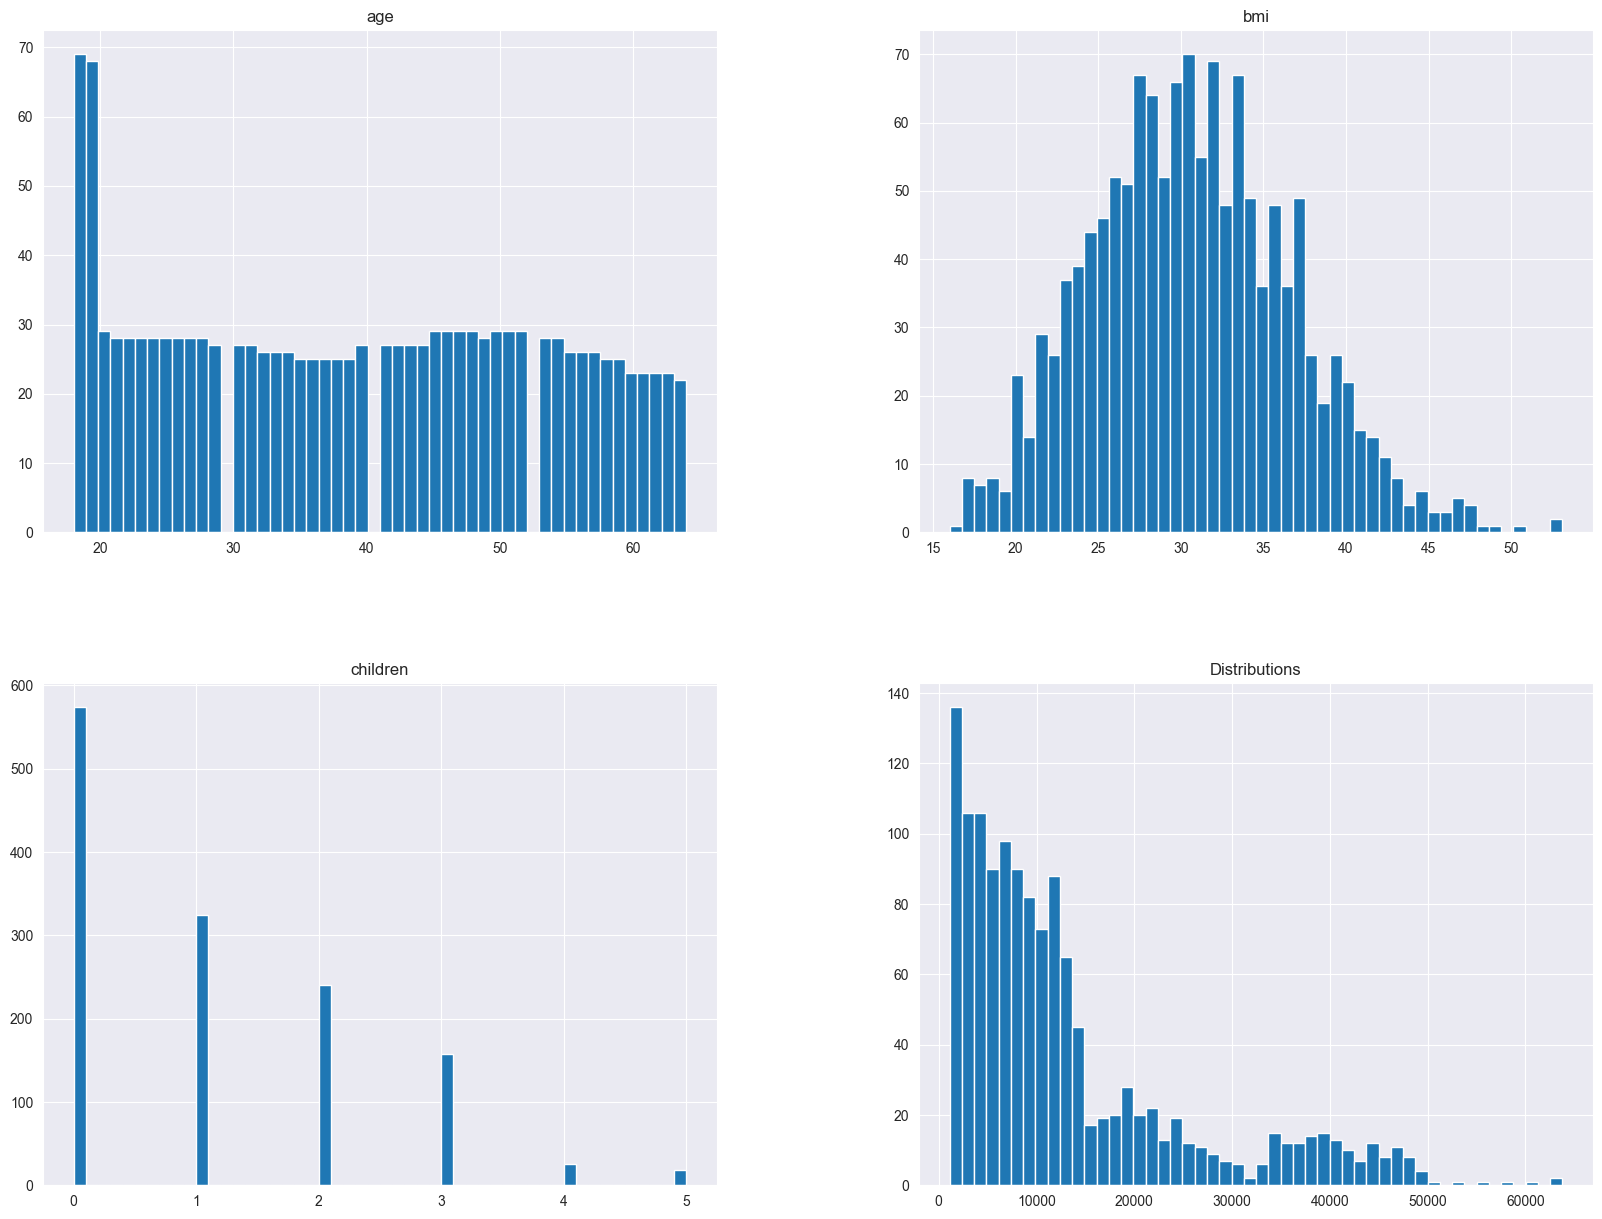

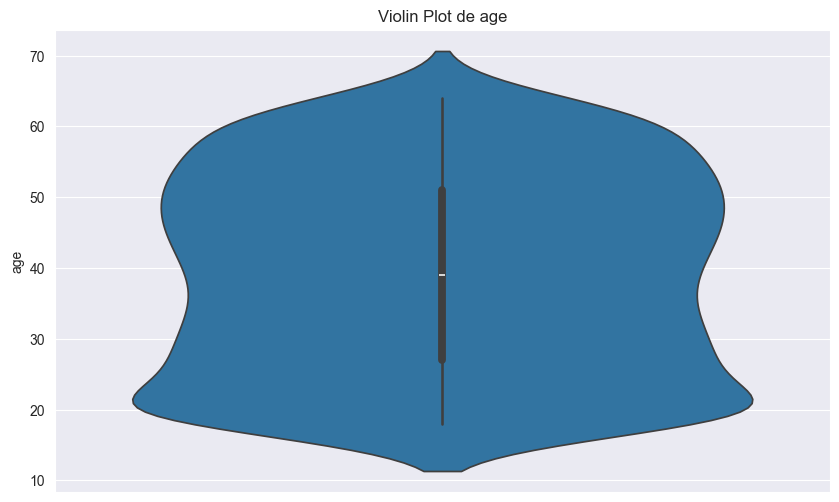

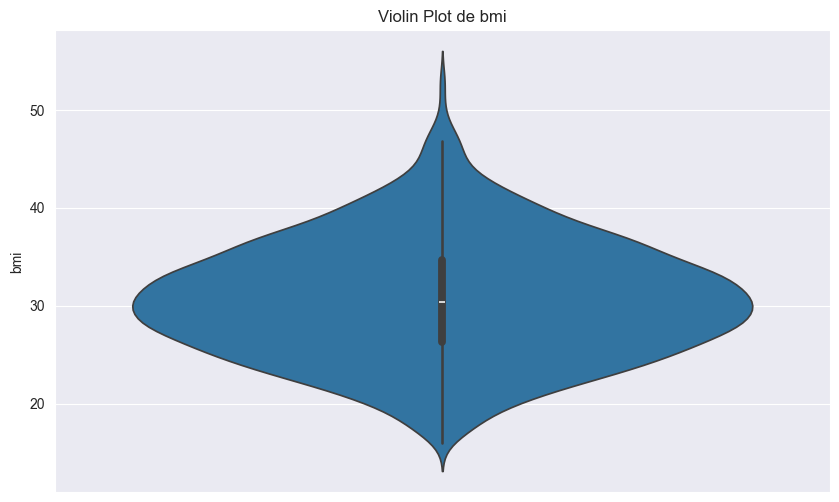

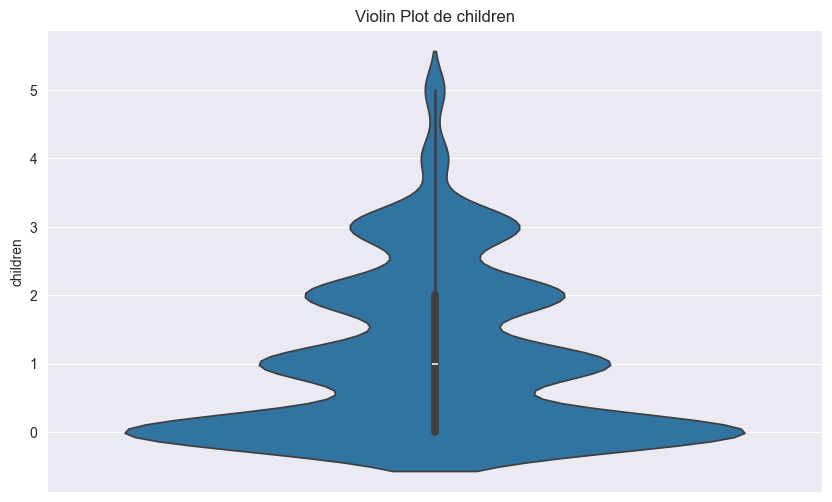

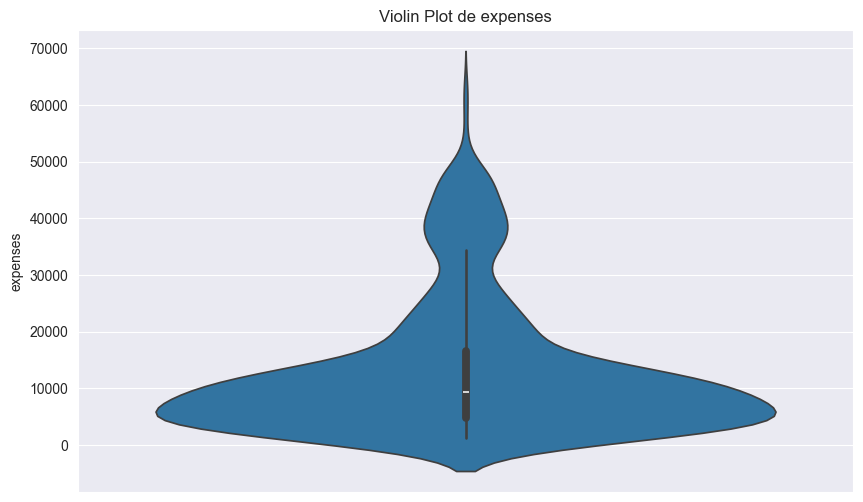

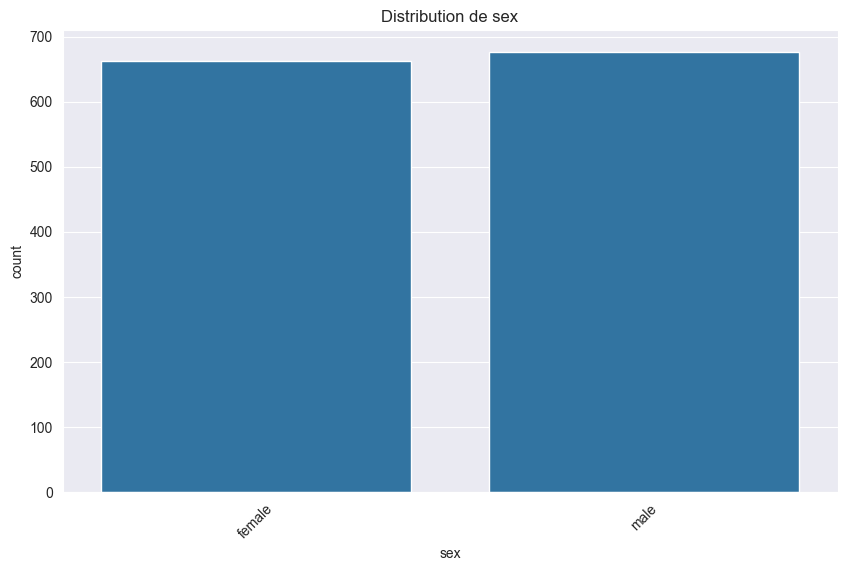

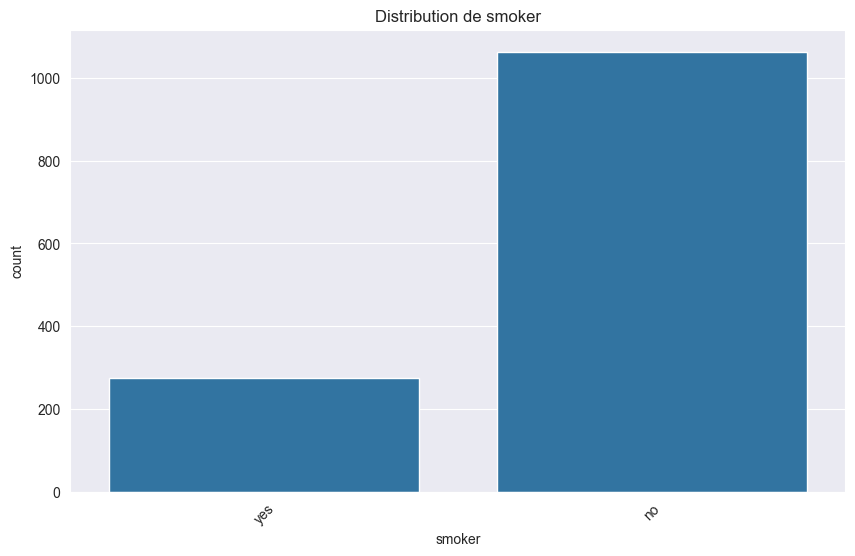

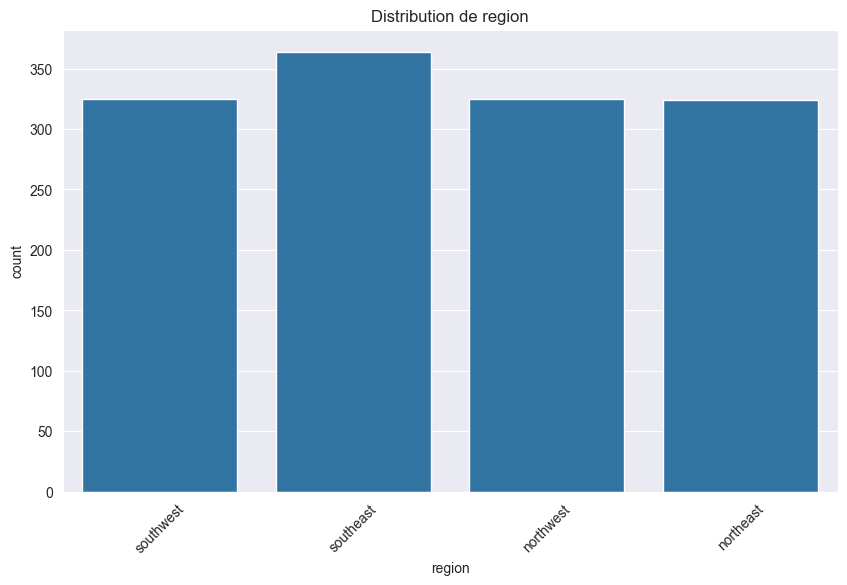

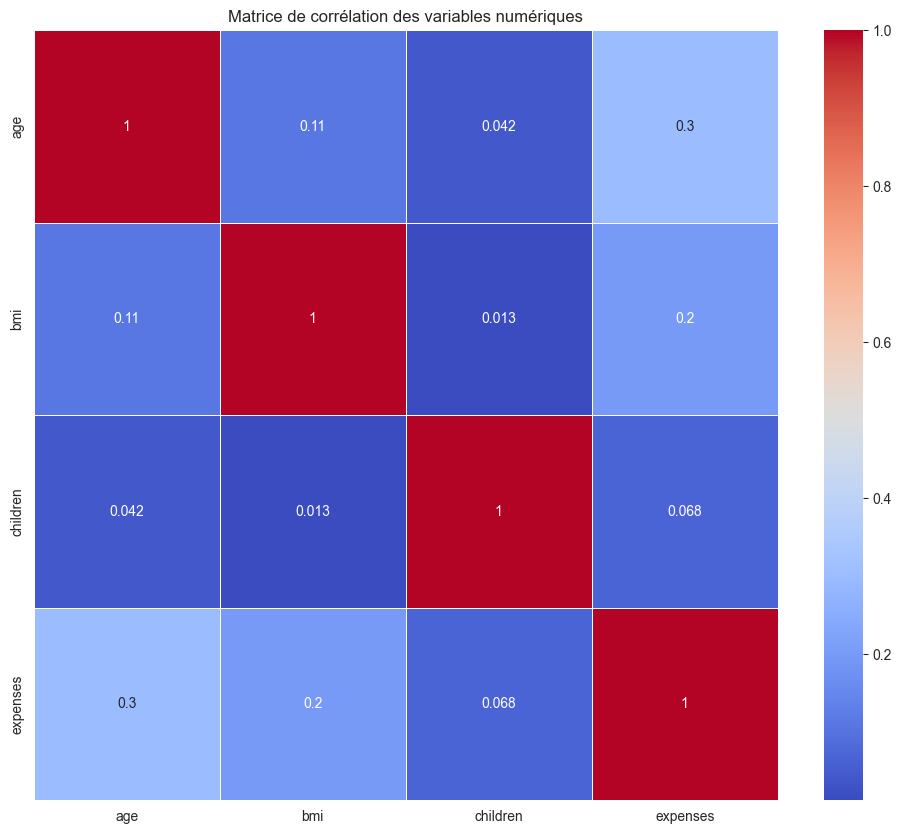

In [5]:
# Définitions des fonctions utiles
def distributions_hist(df):
    df.hist(bins=50, figsize=(20,15))
    plt.title('Distributions')
    plt.show()

def columns_separation(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    categorical_columns = df.select_dtypes(exclude=[np.number]).columns
    return numeric_columns, categorical_columns

def numerical_violins(numeric_columns):
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.violinplot(y=column, data=df)
        plt.title(f'Violin Plot de {column}')
        plt.show()

def categorical_countplots(categorical_columns):
    for column in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution de {column}')
        plt.xticks(rotation=45)
        plt.show()

def numerical_correlation_matrix(df, numeric_columns=None):
    plt.figure(figsize=(12, 10))
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=[np.number]).columns
    sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matrice de corrélation des variables numériques')
    plt.show()

# Définition de la target
target_column = 'expenses'
# Visualisation de la distribution des caractéristiques
distributions_hist(df)
# Séparation des colonnes
numeric_columns, categorical_columns = columns_separation(df)
# Violins pour les colonnes numériques
numerical_violins(numeric_columns)
# Countplots pour les colonnes catégoriques
categorical_countplots(categorical_columns)
# Matrice de corrélation pour les variables numériques
numerical_correlation_matrix(df, numeric_columns)


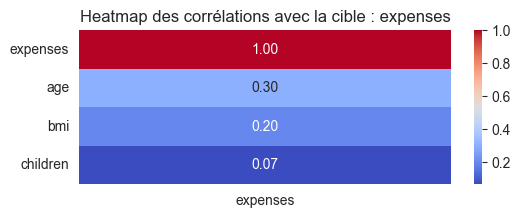

In [6]:
# visualiser les relations entre la cible et certaines caractéristiques
def target_correlation_matrix(df, target_column):
    # Sélection des colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number])

    # Calcul de la matrice de correlation
    correlation_matrix = numeric_cols.corr()

    # Correlation avec la cible
    correlation_with_target = correlation_matrix[target_column].sort_values(ascending=False)

    # Affichage
    plt.figure(figsize=(6, len(correlation_with_target) * 0.5))
    sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title(f'Heatmap des corrélations avec la cible : {target_column}')
    plt.show()

target_correlation_matrix(df, target_column)

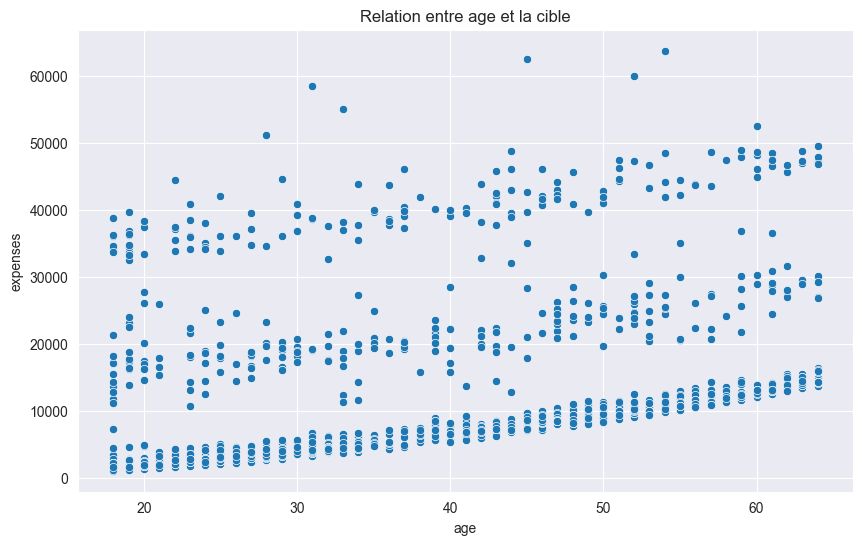

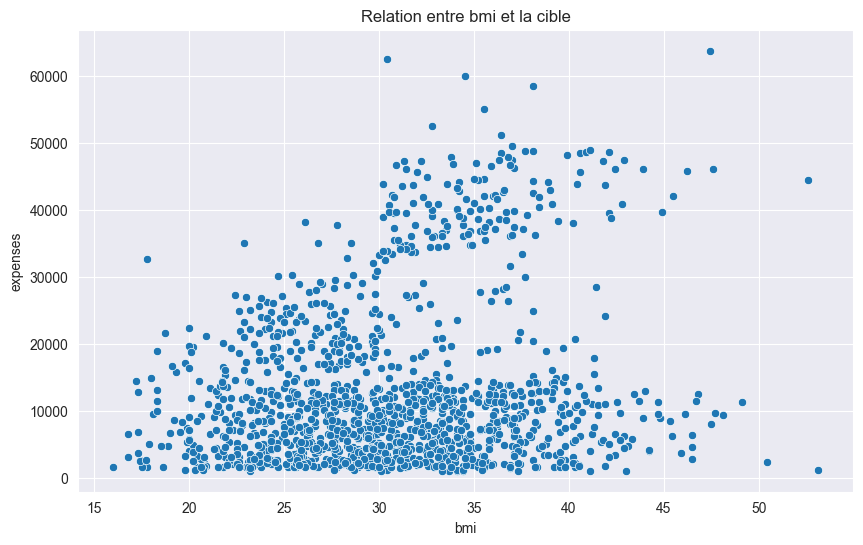

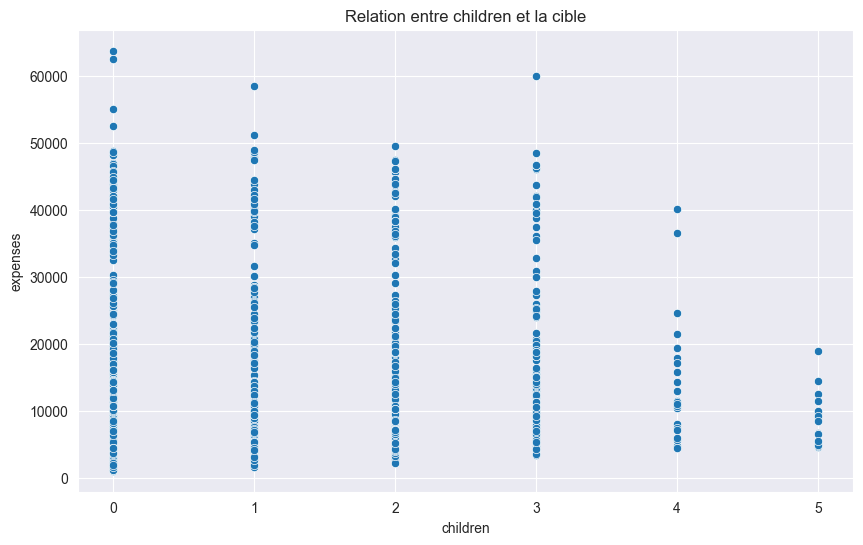

In [7]:
# Relations entre la cible et les variables numériques
def target_numerical_scatterplots(df, numeric_columns, target_column):
    # Exclude the target column
    numeric_columns = [col for col in numeric_columns if col != target_column]
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=column, y=target_column, data=df)
        plt.title(f'Relation entre {column} et la cible')
        plt.show()

target_numerical_scatterplots(df, numeric_columns, target_column)

Traitement des données

In [8]:
# Fonction pour encoder les colonnes binaires en 0 et 1
def encode_binary_columns(df, binary_columns):
    for column in binary_columns:
        # Vérification que la colonne est présente dans le DataFrame
        if column not in df.columns:
            print(f"⚠️ La colonne '{column}' est absente du DataFrame.")
            continue

        # Encodage en 0 et 1
        df[column] = df[column].astype('category').cat.codes

        # Vérification des résultats encodés
        print(f"\nColonne '{column}' après encodage :")
        print(df[column].value_counts())
    return df

# Fonction pour encoder les colonnes non binaires
def encode_non_binary_columns(df, non_binary_columns):
    le = LabelEncoder()  # Initialiser un encodeur
    for column in non_binary_columns:
        # Vérification que la colonne est présente dans le DataFrame
        if column not in df.columns:
            print(f"⚠️ La colonne '{column}' est absente du DataFrame.")
            continue

        # Appliquer le LabelEncoder à chaque colonne non binaire
        df[column] = le.fit_transform(df[column].astype(str))

        # Vérification des résultats encodés
        print(f"\nColonne '{column}' après encodage :")
        print(df[column].value_counts())
    return df

binary_columns = ['sex', 'smoker']
non_binary_columns = ['region']

df = encode_binary_columns(df, binary_columns)
df = encode_non_binary_columns(df, non_binary_columns)

display(df)



Colonne 'sex' après encodage :
sex
1    676
0    662
Name: count, dtype: int64

Colonne 'smoker' après encodage :
smoker
0    1064
1     274
Name: count, dtype: int64

Colonne 'region' après encodage :
region
2    364
3    325
1    325
0    324
Name: count, dtype: int64


,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86
...,...,...,...,...,...,...,...
1333,50,1,31.0,3,0,1,10600.55
1334,18,0,31.9,0,0,0,2205.98
1335,18,0,36.9,0,0,2,1629.83
1336,21,0,25.8,0,0,3,2007.95


Exploration des données après encodage

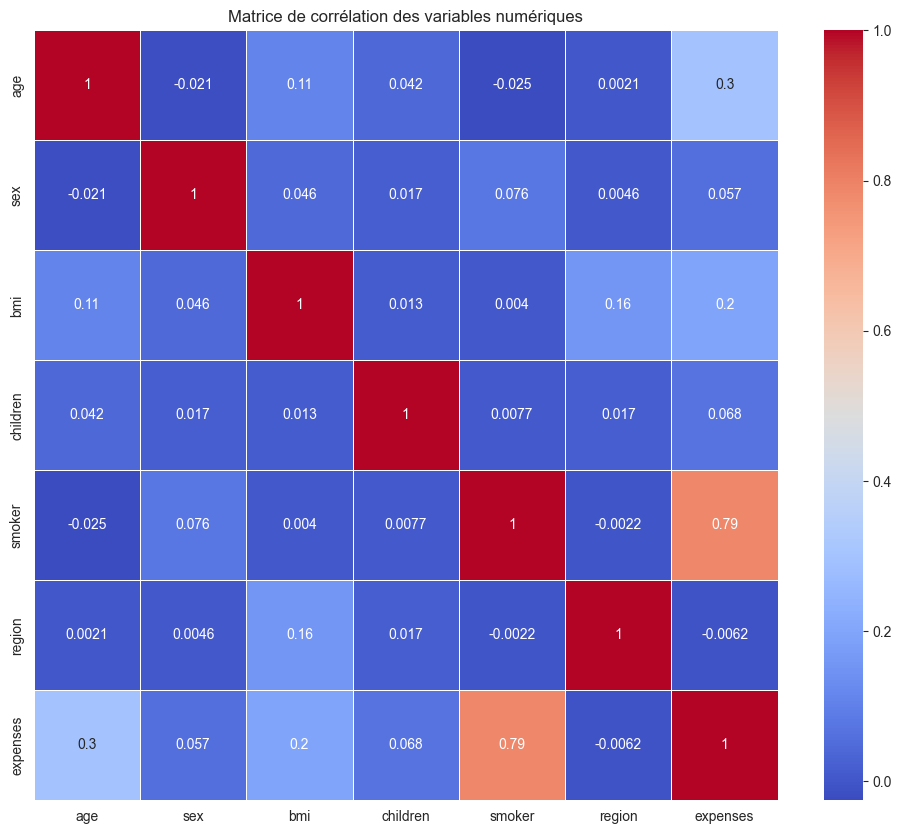

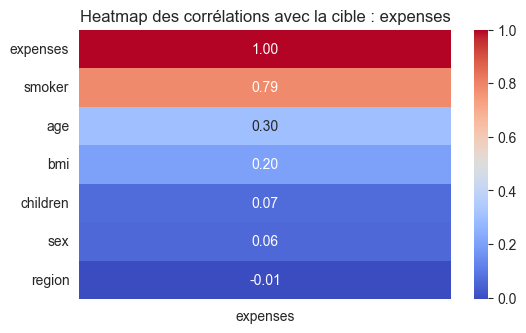

In [9]:
numerical_correlation_matrix(df)
target_correlation_matrix(df, target_column)

Séparation des caractéristiques

In [10]:
x = df.drop(target_column, axis=1)
y = df[target_column]
display(x)
print(y)


,age,sex,bmi,children,smoker,region
0,19,0,27.9,0,1,3
1,18,1,33.8,1,0,2
2,28,1,33.0,3,0,2
3,33,1,22.7,0,0,1
4,32,1,28.9,0,0,1
...,...,...,...,...,...,...
1333,50,1,31.0,3,0,1
1334,18,0,31.9,0,0,0
1335,18,0,36.9,0,0,2
1336,21,0,25.8,0,0,3


0       16884.92
1        1725.55
2        4449.46
3       21984.47
4        3866.86
          ...   
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.95
1337    29141.36
Name: expenses, Length: 1338, dtype: float64


In [ ]:
%%sql


Division des Données en Ensembles d’Entraînement et de Test

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
display(x_train)
display(x_test)
print(y_train)
print(y_test)

,age,sex,bmi,children,smoker,region
560,46,0,20.0,2,0,1
1285,47,0,24.3,0,0,0
1142,52,0,24.9,0,0,2
969,39,0,34.3,5,0,2
486,54,0,21.5,3,0,1
...,...,...,...,...,...,...
1095,18,0,31.4,4,0,0
1130,39,0,23.9,5,0,2
1294,58,1,25.2,0,0,0
860,37,0,47.6,2,1,3


,age,sex,bmi,children,smoker,region
764,45,0,25.2,2,0,0
887,36,0,30.0,0,0,1
890,64,0,26.9,0,1,1
1293,46,1,25.7,3,0,1
259,19,1,31.9,0,1,1
...,...,...,...,...,...,...
109,63,1,35.1,0,1,2
575,58,0,27.2,0,0,1
535,38,1,28.0,1,0,0
543,54,0,47.4,0,1,2


560      9193.84
1285     8534.67
1142    27117.99
969      8596.83
486     12475.35
          ...   
1095     4561.19
1130     8582.30
1294    11931.13
860     46113.51
1126    10214.64
Name: expenses, Length: 1070, dtype: float64
764      9095.07
887      5272.18
890     29330.98
1293     9301.89
259     33750.29
          ...   
109     47055.53
575     12222.90
535      6067.13
543     63770.43
846      9872.70
Name: expenses, Length: 268, dtype: float64


Normalisation ou Standardisation des Données

In [41]:
# 1. Instancier le préprocesseur
std_scaler = StandardScaler()  # Créez une instance de la fonction de prétraitement

# 2. Ajuster et transformer les données d'entraînement
x_train_scaled = std_scaler.fit_transform(x_train)  # Apprend les paramètres et applique la transformation sur X_train

# 3. Transformer les données de test
x_test_scaled = std_scaler.transform(x_test)  # Utilise les mêmes paramètres pour transformer X_test

# 4. Afficher les données transformées
print(x_train_scaled)
print(x_test_scaled)

[[ 0.47222651 -1.0246016  -1.74857248  0.73433626 -0.50874702 -0.45611589]
 [ 0.54331294 -1.0246016  -1.03670397 -0.91119211 -0.50874702 -1.35325561]
 [ 0.8987451  -1.0246016  -0.93737348 -0.91119211 -0.50874702  0.44102382]
 ...
 [ 1.3252637   0.97598911 -0.88770823 -0.91119211 -0.50874702 -1.35325561]
 [-0.16755139 -1.0246016   2.82063006  0.73433626  1.96561348  1.33816354]
 [ 1.1120044   0.97598911 -0.1096194  -0.91119211 -0.50874702  1.33816354]]
[[ 0.40114007 -1.0246016  -0.88770823  0.73433626 -0.50874702 -1.35325561]
 [-0.23863782 -1.0246016  -0.09306431 -0.91119211 -0.50874702 -0.45611589]
 [ 1.75178229 -1.0246016  -0.60627185 -0.91119211  1.96561348 -0.45611589]
 ...
 [-0.09646495  0.97598911 -0.42416595 -0.08842793 -0.50874702 -1.35325561]
 [ 1.04091797 -1.0246016   2.7875199  -0.91119211  1.96561348  0.44102382]
 [ 0.82765867 -1.0246016   0.60224912 -0.08842793 -0.50874702  1.33816354]]


Modèles de régression

In [63]:
def get_regression_models():
    # Initialisation des modèles de régression
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Bayesian Ridge Regression': BayesianRidge(),
        'Random Forest Regressor': RandomForestRegressor(),
        'Gradient Boosting Regressor': GradientBoostingRegressor(),
    }

    return models

Grilles de paramètres

In [62]:
def get_hyperparameter_grids():
    # Dictionnaire contenant les grilles d'hyperparamètres pour chaque modèle
    param_grids = {
        'Linear Regression': {
            'fit_intercept': Categorical([True, False]), # Si le modèle doit calculer l'ordonnée à l'origine
            'positive': Categorical([True, False])  # Contraindre les coefficients à être positifs
        },
        'Ridge Regression': {
            'alpha': Real(1e-6, 1e+6, prior='log-uniform'),  # Paramètre de régularisation
            'fit_intercept': Categorical([True, False]),
        },
        'Bayesian Ridge Regression': {
            'alpha_1': Real(1e-6, 1e+6, prior='log-uniform'),
            'alpha_2': Real(1e-6, 1e+6, prior='log-uniform'),
            'lambda_1': Real(1e-6, 1e+6, prior='log-uniform'),
            'lambda_2': Real(1e-6, 1e+6, prior='log-uniform'),
            'fit_intercept': Categorical([True, False])
        },
        'Random Forest Regressor': {
            'n_estimators': (50, 500),
            'max_depth': (3, 30),
            'min_samples_split': (2, 20),
            'min_samples_leaf': (1, 20),
            'max_features': ['sqrt', 'log2', None]  # Remplacement de 'auto'
        },
        'Gradient Boosting Regressor': {
            'n_estimators': (50, 500),
            'max_depth': (3, 30),
            'learning_rate': (0.01, 0.5, 'log-uniform'),
            'subsample': (0.5, 1.0),
            'loss': ['squared_error', 'absolute_error', 'huber']  # Utilisation des noms complets
        },
    }

    return param_grids

Optimisations des modèles

In [64]:
def hyperparameter_search(model_name, model, search_method, param_grid, x_train_scaled, y_train, scoring='r2'):
    """
    Effectue une recherche d'hyperparamètres pour un modèle donné en utilisant la méthode spécifiée.

    Paramètres :
        - model_name : Nom du modèle (string).
        - model : Modèle à optimiser.
        - search_method : Méthode de recherche (`BayesSearchCV`, `GridSearchCV`, ou `RandomizedSearchCV`).
        - param_grid : Grille des hyperparamètres.
        - x_train_scaled : Données d'entraînement (features, après scaling si nécessaire).
        - y_train : Données d'entraînement (cibles).
        - scoring : Métrique d'évaluation (par défaut 'r2').

    Retourne :
        - Le modèle optimisé avec les meilleurs hyperparamètres.
    """
    print(f"{search_method.__name__} : Optimisation du modèle {model_name}...")

    # Initialisation de la méthode de recherche
    if search_method == BayesSearchCV:
        search = search_method(
            estimator=model,
            search_spaces=param_grid,
            n_iter=param_grid.get('n_iter', 50),  # Défaut : 30 itérations si non défini
            cv=5,
            scoring=scoring,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
    elif search_method in [GridSearchCV, RandomizedSearchCV]:
        search = search_method(
            estimator=model,
            param_distributions=param_grid if search_method == RandomizedSearchCV else None,
            param_grid=param_grid if search_method == GridSearchCV else None,
            n_iter=param_grid.get('n_iter', 50) if search_method == RandomizedSearchCV else None,
            cv=5,
            scoring=scoring,
            verbose=1,
            n_jobs=-1
        )
    else:
        raise ValueError(f"Méthode de recherche {search_method.__name__} non prise en charge.")

    # Entraînement de la recherche
    search.fit(x_train_scaled, y_train)

    # Résultats
    print(f"{search_method.__name__} : Meilleur score pour {model_name} : {search.best_score_}")
    print(f"{search_method.__name__} : Meilleurs hyperparamètres pour {model_name} : {search.best_params_}")

    # Retourne le meilleur modèle
    return search.best_estimator_


def get_best_models(models, param_grids, search_method, x_train_scaled, y_train, scoring='r2'):
    """
    Optimise une liste de modèles avec une méthode de recherche spécifiée.

    Paramètres :
        - models : Dictionnaire de modèles à optimiser (nom -> modèle).
        - param_grids : Dictionnaire de grilles d'hyperparamètres (nom -> grille).
        - search_method : Méthode de recherche (`BayesSearchCV`, `GridSearchCV`, ou `RandomizedSearchCV`).
        - x_train_scaled : Données d'entraînement (features, après scaling si nécessaire).
        - y_train : Données d'entraînement (cibles).
        - scoring : Métrique d'évaluation (par défaut 'r2').

    Retourne :
        - Un dictionnaire contenant les meilleurs modèles.
    """
    best_models = {}

    for model_name, model in models.items():
        print(f"Optimisation pour le modèle : {model_name}")

        # Vérifie si la grille d'hyperparamètres est définie pour ce modèle
        if model_name not in param_grids:
            print(f"Aucune grille d'hyperparamètres définie pour {model_name}. Le modèle sera utilisé avec ses paramètres par défaut.")
            best_models[model_name] = model
            continue

        # Recherche des meilleurs hyperparamètres pour le modèle
        best_model = hyperparameter_search(
            model_name=model_name,
            model=model,
            search_method=search_method,
            param_grid=param_grids[model_name],
            x_train_scaled=x_train_scaled,
def display_model_coefficients(models, x_train, feature_names):
    """
    Affiche les coefficients ou les caractéristiques importantes de chaque modèle optimisé.

    Paramètres :
        - models : Dictionnaire des modèles optimisés.
        - x_train : Données d'entraînement (numpy array ou DataFrame).
        - feature_names : Liste des noms des caractéristiques.
    """
    for model_name, model in models.items():
        print(f"\nModèle : {model_name}")

        # Si le modèle est une régression linéaire ou un modèle similaire avec des coefficients
        if hasattr(model, 'coef_'):
            if model_name == 'Linear Regression':  # Pour la régression linéaire
                coefficients = pd.DataFrame({
                    'Variable': feature_names,
                    'Coefficient': model.coef_
                })
                print("Coefficients de la régression linéaire optimisée :")
                print(coefficients)

                # Visualiser les coefficients sous forme de barres
                plt.figure(figsize=(8, 6))
                plt.barh(feature_names, model.coef_, color='skyblue')
                plt.xlabel("Coefficient")
                plt.ylabel("Variable")
                plt.title(f"Importance des variables dans la {model_name}")
                plt.show()

        # Si le modèle est un modèle basé sur des arbres, comme RandomForest, GradientBoosting, etc.
        elif hasattr(model, 'feature_importances_'):
            feature_importances = pd.DataFrame({
                'Variable': feature_names,
                'Importance': model.feature_importances_
            })
            print("Importances des variables pour", model_name, ":")
            print(feature_importances)

            # Visualiser les importances sous forme de barres
            plt.figure(figsize=(8, 6))
            plt.barh(feature_names, model.feature_importances_, color='lightgreen')
            plt.xlabel("Importance")
            plt.ylabel("Variable")
            plt.title(f"Importance des variables dans {model_name}")
            plt.show()

        # Si le modèle n'a pas de coefficients ou d'importances accessibles directement, ignorer
        else:
            print(f"Le modèle {model_name} ne fournit pas de coefficients ou d'importances.")

# Obtenir les noms des caractéristiques
feature_names = x.columns.tolist()

# Appeler la fonction avec les noms des caractéristiques
display_model_coefficients(best_models, x_train_scaled, feature_names)
            y_train=y_train,
            scoring=scoring
        )
        # Stockage du meilleur modèle
        best_models[model_name] = best_model

    return best_models

Récupération des modèles et des grilles et Recherche des meilleurs modèles

In [66]:
models = get_regression_models()
param_grids = get_hyperparameter_grids()
best_models = get_best_models(models, param_grids, BayesSearchCV, x_train_scaled, y_train)
print(best_models)

Optimisation pour le modèle : Linear Regression
BayesSearchCV : Optimisation du modèle Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.False_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.False_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.False_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.False_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [False, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.True_] before, using random point [True, True]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
BayesSearchCV : Meilleur score pour Linear Regression : 0.7345462675393406
BayesSearchCV : Meilleurs hyperparamètres pour Linear Regression : OrderedDict({'fit_intercept': True, 'positive': True})
Optimisation pour le modèle : Ridge Regression
BayesSearchCV : Optimisation du modèle Ridge Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totall

C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.000367915155759e-06, np.True_] before, using random point [0.0023565963245292328, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Program Files\Python313\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.002659063411018e-06, np.True_] before, using random point [0.0027870713020222435, False]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
BayesSearchCV : Meilleur score pour Ridge Regression : 0.7340233047493635
BayesSearchCV : Meilleurs hyperparamètres pour Ridge Regression : OrderedDict({'alpha': 5.806599860670562, 'fit_intercept': True})
Optimisation pour le modèle : Bayesian Ridge Regression
BayesSearchCV : Optimisation du modèle Bayesian Ridge Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for ea

C:\Users\Utilisateur\AppData\Roaming\Python\Python313\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Utilisateur\AppData\Roaming\Python\Python313\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Prédictions

<Figure size 1200x600 with 0 Axes>

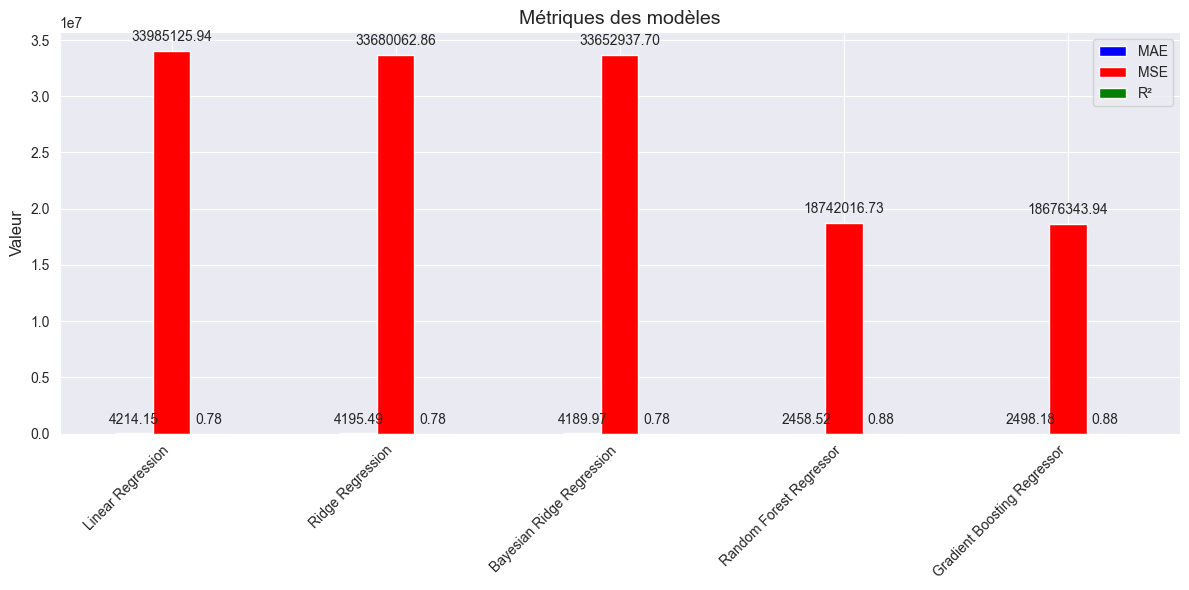


Métriques des modèles :


,MAE,MSE,R²
Linear Regression,4214.146361,3.398513e+07,0.781092
Ridge Regression,4195.485755,3.368006e+07,0.783057
Bayesian Ridge Regression,4189.965534,3.365294e+07,0.783232
Random Forest Regressor,2458.515658,1.874202e+07,0.879277
Gradient Boosting Regressor,2498.184107,1.867634e+07,0.879701



Comparaison des prédictions avec les valeurs réelles :

Linear Regression :


,Valeurs réelles (y_test),Prédictions (y_pred)
764,9095.07,8558.038697
887,5272.18,6962.334745
890,29330.98,36796.339125
1293,9301.89,9406.498864
259,33750.29,26867.385925
...,...,...
109,47055.53,39226.324740
575,12222.90,11699.978478
535,6067.13,7248.628923
543,63770.43,40943.404585



Ridge Regression :


,Valeurs réelles (y_test),Prédictions (y_pred)
764,9095.07,8949.588823
887,5272.18,7136.971337
890,29330.98,36771.213472
1293,9301.89,9517.528142
259,33750.29,26933.134968
...,...,...
109,47055.53,38978.329056
575,12222.90,11822.375765
535,6067.13,7661.364375
543,63770.43,40802.921474



Bayesian Ridge Regression :


,Valeurs réelles (y_test),Prédictions (y_pred)
764,9095.07,8938.057245
887,5272.18,7118.782787
890,29330.98,36861.122179
1293,9301.89,9501.260347
259,33750.29,26979.617571
...,...,...
109,47055.53,39068.651092
575,12222.90,11822.682187
535,6067.13,7640.478589
543,63770.43,40901.474161



Random Forest Regressor :


,Valeurs réelles (y_test),Prédictions (y_pred)
764,9095.07,10789.731518
887,5272.18,5882.297166
890,29330.98,27459.544717
1293,9301.89,10419.493707
259,33750.29,34791.113321
...,...,...
109,47055.53,47178.834209
575,12222.90,12706.465783
535,6067.13,7179.636536
543,63770.43,47109.043833



Gradient Boosting Regressor :


,Valeurs réelles (y_test),Prédictions (y_pred)
764,9095.07,10798.594123
887,5272.18,6350.518253
890,29330.98,26763.062339
1293,9301.89,10124.992776
259,33750.29,34803.397991
...,...,...
109,47055.53,45751.817206
575,12222.90,12785.646590
535,6067.13,7326.903664
543,63770.43,46711.659103


In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour prédire et comparer les résultats
def predict_and_compare(best_models, x_test, y_test):
    comparisons = {}

    for model_name, model in best_models.items():
        # Faire des prédictions avec le modèle
        predictions = model.predict(x_test)

        # Comparer les valeurs réelles et les prédictions
        comparison = pd.DataFrame({
            'Valeurs réelles (y_test)': y_test,
            'Prédictions (y_pred)': predictions
        })
        comparisons[model_name] = comparison

    return comparisons

# Fonction pour calculer les métriques
def calculate_metrics(best_models, x_test, y_test):
    metrics_data = {}

    for model_name, model in best_models.items():
        predictions = model.predict(x_test)

        # Calcul des métriques
        metrics = {
            'MAE': mean_absolute_error(y_test, predictions),
            'MSE': mean_squared_error(y_test, predictions),
            'R²': r2_score(y_test, predictions)
        }
        metrics_data[model_name] = metrics

    return metrics_data

# Fonction pour afficher les résultats avec fond clair et couleurs des barres visibles
def display_metrics(metrics_data):
    # Convertir les métriques en DataFrame
    metrics_df = pd.DataFrame(metrics_data).T

    # Afficher un graphique en barres avec les métriques
    plt.figure(figsize=(12, 6), facecolor='white')  # Changer le fond de la figure en blanc
    ax = metrics_df.plot(kind='bar', color=['blue', 'red', 'green'], figsize=(12, 6))  # Changer les couleurs des barres
    plt.title('Métriques des modèles', fontsize=14)
    plt.ylabel('Valeur', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right', fontsize=10)

    # Affichage des valeurs sur chaque barre
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Affichage du tableau des métriques pour les modèles
    print("\nMétriques des modèles :")
    display(metrics_df)

# Fonction principale qui combine prédiction, calcul des métriques et affichage
def predict_with_optimized_models(best_models, x_test, y_test):
    # Prédire et comparer les résultats
    comparisons = predict_and_compare(best_models, x_test, y_test)

    # Calculer les métriques
    metrics_data = calculate_metrics(best_models, x_test, y_test)

    # Afficher les résultats
    display_metrics(metrics_data)

    return comparisons, metrics_data

# Utiliser la fonction principale
comparisons, metrics_data = predict_with_optimized_models(best_models, x_test_scaled, y_test)

# Afficher les comparaisons si nécessaire
print("\nComparaison des prédictions avec les valeurs réelles :")
for model_name, comparison in comparisons.items():
    print(f"\n{model_name} :")
    display(comparison)



Interprétation des Coefficients et des Caractéristiques


Modèle : Linear Regression
Coefficients du modèle Linear Regression :
   Variable  Coefficient
0       age  3616.064763
1       sex     0.000000
2       bmi  1979.378055
3  children   519.666758
4    smoker  9558.974153
5    region     0.000000


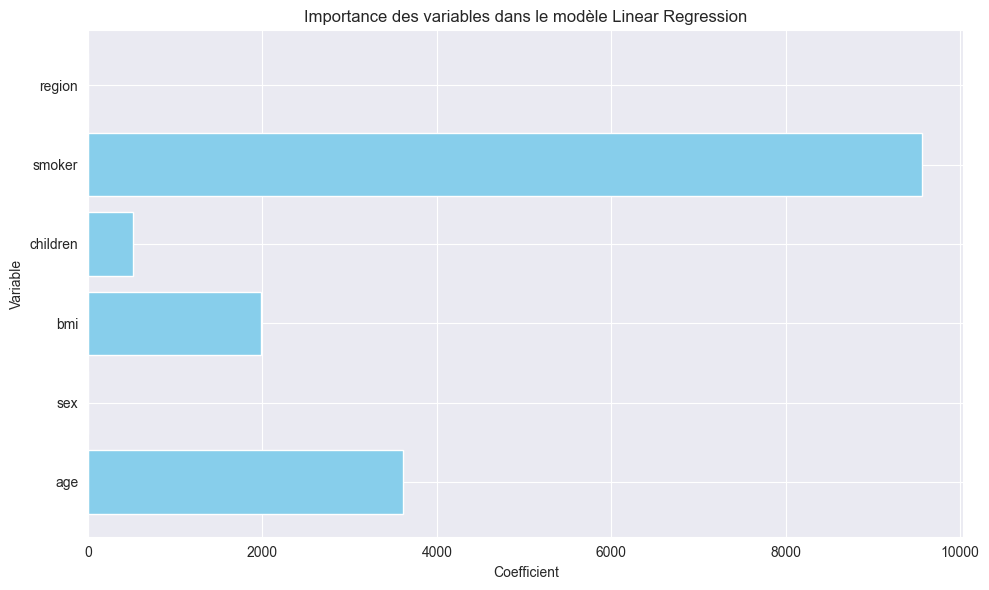


Modèle : Ridge Regression
Coefficients du modèle Ridge Regression :
   Variable  Coefficient
0       age  3594.708858
1       sex    -5.540723
2       bmi  2020.023261
3  children   516.260597
4    smoker  9503.850578
5    region  -299.262162


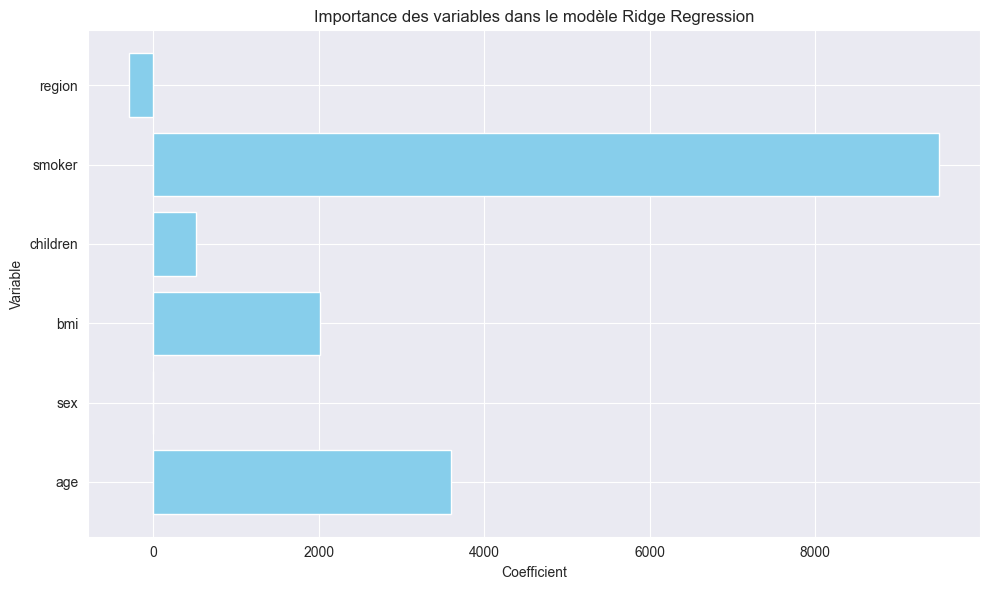

Paramètre alpha pour Ridge Regression: 5.806599860670562

Modèle : Bayesian Ridge Regression
Coefficients du modèle Bayesian Ridge Regression :
   Variable  Coefficient
0       age  3608.286626
1       sex    -7.981986
2       bmi  2025.932797
3  children   516.811417
4    smoker  9537.841022
5    region  -301.223733


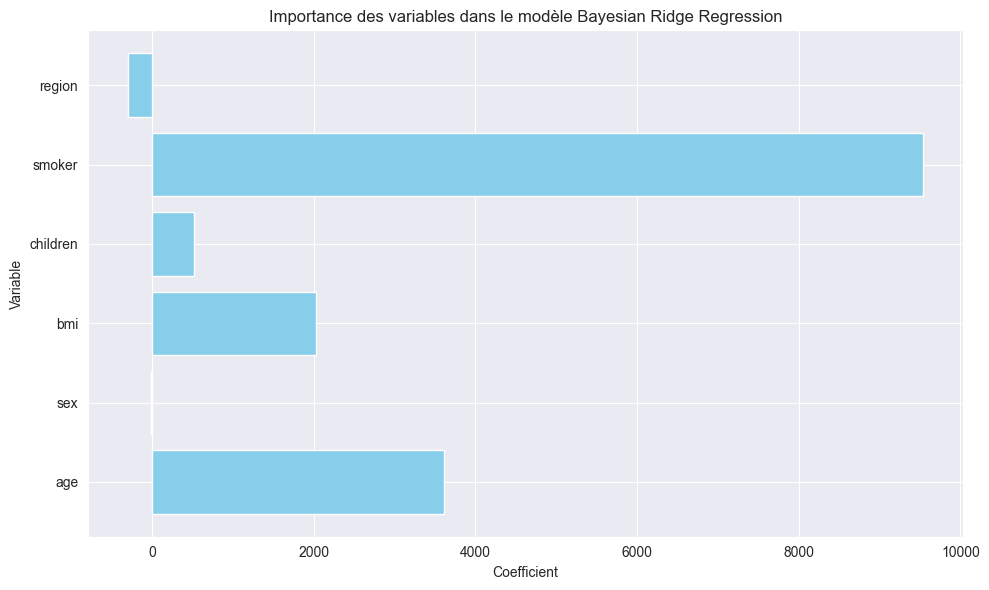

Paramètre alpha pour Bayesian Ridge Regression: 2.6675739513024543e-08

Modèle : Random Forest Regressor
Importances des variables pour Random Forest Regressor:
   Variable  Importance
0       age    0.118025
1       sex    0.000802
2       bmi    0.180051
3  children    0.008269
4    smoker    0.689755
5    region    0.003098


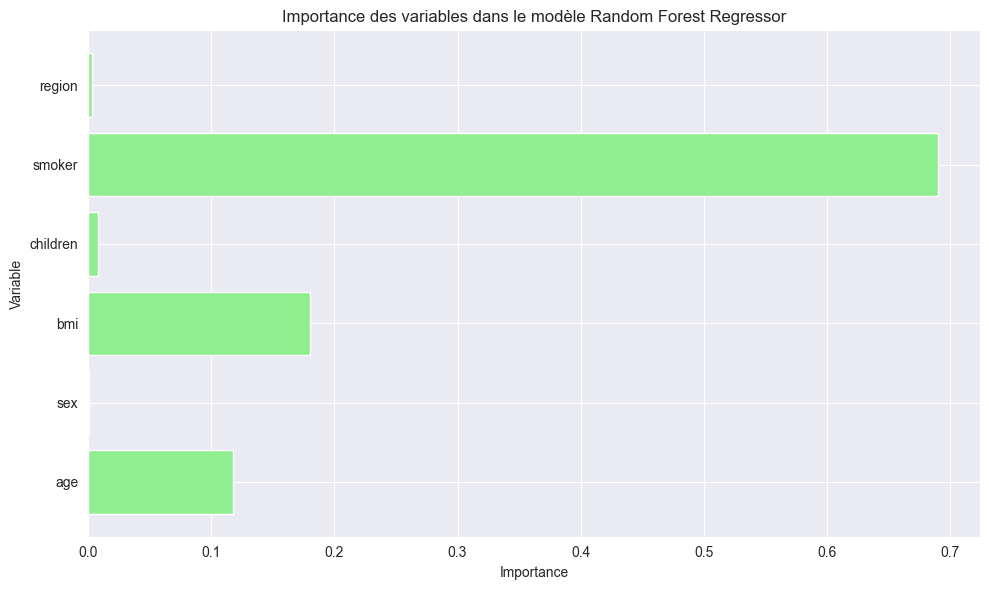


Modèle : Gradient Boosting Regressor
Importances des variables pour Gradient Boosting Regressor:
   Variable  Importance
0       age    0.122644
1       sex    0.000889
2       bmi    0.181781
3  children    0.010910
4    smoker    0.680185
5    region    0.003592


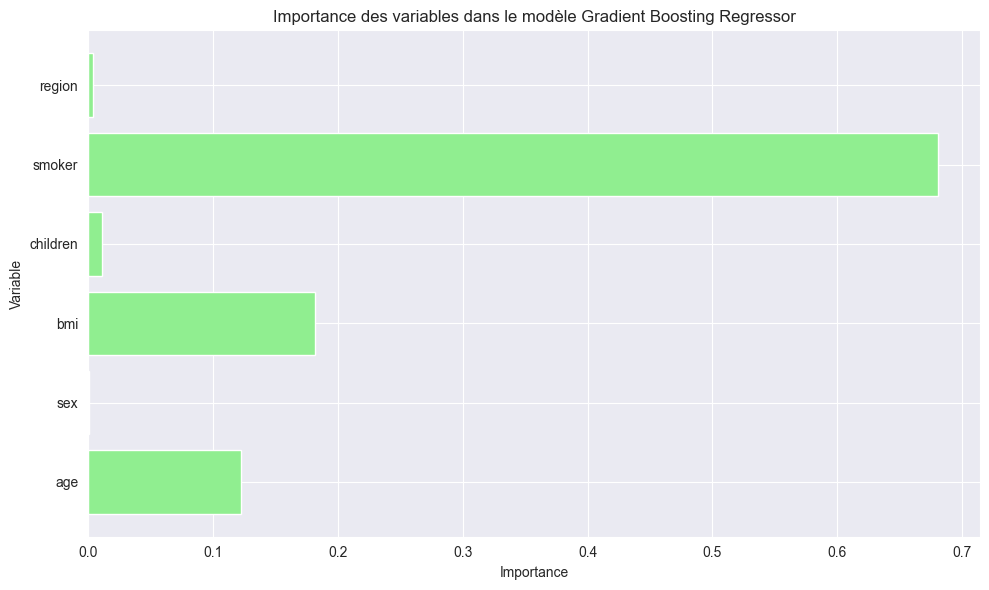

In [77]:
def display_model_coefficients(models, x_train, feature_names):
    """
    Affiche les coefficients ou les caractéristiques importantes de chaque modèle optimisé.

    Paramètres :
        - models : Dictionnaire des modèles optimisés.
        - x_train : Données d'entraînement (numpy array ou DataFrame).
        - feature_names : Liste des noms des caractéristiques.
    """
    for model_name, model in models.items():
        print(f"\nModèle : {model_name}")

        # Si le modèle a des coefficients (Linear Regression, Ridge, Bayesian Ridge)
        if hasattr(model, 'coef_'):
            coefficients = pd.DataFrame({
                'Variable': feature_names,
                'Coefficient': model.coef_
            })
            print(f"Coefficients du modèle {model_name} :")
            print(coefficients)

            # Visualiser les coefficients sous forme de barres
            plt.figure(figsize=(10, 6))
            plt.barh(feature_names, model.coef_, color='skyblue')
            plt.xlabel("Coefficient")
            plt.ylabel("Variable")
            plt.title(f"Importance des variables dans le modèle {model_name}")
            plt.tight_layout()
            plt.show()

            # Pour Ridge et Bayesian Ridge, afficher le paramètre alpha
            if model_name in ['Ridge Regression', 'Bayesian Ridge Regression']:
                if hasattr(model, 'alpha_'):
                    print(f"Paramètre alpha pour {model_name}: {model.alpha_}")
                elif hasattr(model, 'alpha'):
                    print(f"Paramètre alpha pour {model_name}: {model.alpha}")

        # Si le modèle est basé sur des arbres (Random Forest, Gradient Boosting)
        elif hasattr(model, 'feature_importances_'):
            feature_importances = pd.DataFrame({
                'Variable': feature_names,
                'Importance': model.feature_importances_
            })
            print(f"Importances des variables pour {model_name}:")
            print(feature_importances)

            # Visualiser les importances sous forme de barres
            plt.figure(figsize=(10, 6))
            plt.barh(feature_names, model.feature_importances_, color='lightgreen')
            plt.xlabel("Importance")
            plt.ylabel("Variable")
            plt.title(f"Importance des variables dans le modèle {model_name}")
            plt.tight_layout()
            plt.show()

        # Si le modèle n'a pas de coefficients ou d'importances accessibles directement
        else:
            print(f"Le modèle {model_name} ne fournit pas de coefficients ou d'importances directement accessibles.")

# Obtenir les noms des caractéristiques
feature_names = x.columns.tolist()

# Appeler la fonction avec les noms des caractéristiques
display_model_coefficients(best_models, x_train_scaled, feature_names)

Détermination du meilleur modèle

In [86]:
def select_best_model(metrics_data):
    """
    Sélectionne le meilleur modèle basé sur les métriques MAE, MSE et R².

    Paramètres :
        - metrics_data : Dictionnaire des métriques des modèles (nom -> {MAE, MSE, R²}).

    Retourne :
        - Le nom du meilleur modèle basé sur les critères définis.
    """
    # Convertir le dictionnaire de métriques en DataFrame
    metrics_df = pd.DataFrame(metrics_data).T

    # Trier par les métriques
    best_model_mae = metrics_df['MAE'].idxmin()  # Minimiser MAE
    best_model_mse = metrics_df['MSE'].idxmin()  # Minimiser MSE
    best_model_r2 = metrics_df['R²'].idxmax()   # Maximiser R²

    # Afficher les résultats pour chaque métrique
    print(f"\nMeilleur modèle basé sur MAE : {best_model_mae}")
    print(f"Meilleur modèle basé sur MSE : {best_model_mse}")
    print(f"Meilleur modèle basé sur R² : {best_model_r2}")

    # Déterminer un critère global : Par exemple, si un modèle est le meilleur sur 2/3 des métriques, on le choisit
    model_scores = {
        best_model_mae: 1,
        best_model_mse: 1,
        best_model_r2: 1
    }

    # Trouver le modèle qui a le plus de "votes"
    best_model = max(model_scores, key=model_scores.get)

    print(f"\nMeilleur modèle global : {best_model}")

    return best_model

best_model = select_best_model(metrics_data)
print(f"Le modèle sélectionné est : {best_model}")


Meilleur modèle basé sur MAE : Random Forest Regressor
Meilleur modèle basé sur MSE : Gradient Boosting Regressor
Meilleur modèle basé sur R² : Gradient Boosting Regressor

Meilleur modèle global : Random Forest Regressor
Le modèle sélectionné est : Random Forest Regressor


PRISE EN COMPTE DES RESULTATS

In [ ]:
Utilisation prioritaire de Random Forest Regressor, et éventuellement de Gradient Boosting Regressor (certains modèles ont été rejetés de base par souci de préserver le temps de calcul)

Features = smoker, bmi, age

Prévoir de recommencer la logique en ne tenant compte que de ces deux modèles et ces trois features